# Import Packages

In [46]:
# General
import pandas as pd
import numpy as np
from datetime import datetime
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Text pre-processing
import re
import gensim
from gensim.parsing.porter import PorterStemmer
stop_list = gensim.parsing.preprocessing.STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

# for saving and loading data
import pickle

# Import Data

In [47]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: c:\clyerica\Text Analytics Proj


In [48]:
data_directory = os.path.join(current_directory, 'data')
print("Input data directory:", data_directory)

Input data directory: c:\clyerica\Text Analytics Proj\data


In [49]:
output_directory = os.path.join(current_directory, 'output')
print("Output data directory:", output_directory)

Output data directory: c:\clyerica\Text Analytics Proj\output


In [50]:
# Read processed data
job_path = os.path.join(data_directory, 'data_cleaned_1.csv')
jobs_df = pd.read_csv(job_path)

In [51]:
# Drop 6 records where description is all Chinese (resulting in NA after cleaning)
jobs_df = jobs_df.dropna(subset=["processed_title+desc"])
print(jobs_df.isna().sum())

job_id                      0
job_title                   0
company                     0
descriptions                0
State                       0
merged_category             0
category                    0
subcategory                 0
role_clean                  0
type_clean                  0
salary                  35496
processed_title+desc        0
processed_text              0
dtype: int64


In [52]:
# convert "type_clean" into list
jobs_df["type_clean"] = jobs_df["type_clean"].str.lower().str.split(", ").apply(list)

### Clean `company` Field and Create Gazatteer (`companies`)
The cleaned `company_clean` field will be part of the jobs_df data for filtering later after matches are found  
The deduplicated `company_clean` values will become the gazatteer (`companies`)

In [53]:
def normalize_text_company(text):
    text = text.lower()                                    # lowercase
    text = re.sub(r'\([^)]*\)|\[[^\]]*\]', "", text)       # remove text within parenthesis or square brackets
    text = re.sub(r'&', 'and', text)                       # convert & to and
    text = re.sub(r'malaysia|sdn|bhd|sb| s b|berhad|pte|plt|pty|group|holdings|co\.|ltd\.| ltd', '', text).strip()
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)            # keep letters & numbers only
    text = re.sub(r'\s+', ' ', text).strip()               # normalize spaces

    if re.fullmatch(r'\d+', text):
        return ""   # clean off entire field if all only digits (12 digit numbers is the Malaysian company reg no. but no use here)
    
    return text

jobs_df['company_clean'] = jobs_df['company'].apply(normalize_text_company)
jobs_df['company_clean'] = jobs_df['company_clean'].replace('', 'nil')

In [54]:
# Create gazatteer as a list
companies = jobs_df['company_clean'].unique()
companies.sort()

# Cleaning text fields (job_title and descriptions) for BERT

In [55]:
# combine title and description separated with a fullstop and space
jobs_df['title_desc']=jobs_df["job_title"].fillna('') + ". " + jobs_df["descriptions"].fillna('')

def normalize_text_bert(text):
    text = re.sub(r'<.*?>', ' ', text)                     # remove HTML tags
    text = re.sub(r'([^A-Za-z0-9\s])', r' \1 ', text)        # separate punctuation from words/numbers (e.g. executive/assistant -> executive / assistant)
    text = re.sub(r'[ \t]+', ' ', text)               # normalize horizontal spaces
    return text

jobs_df['norm_td']= jobs_df['title_desc'].apply(normalize_text_bert)

In [56]:
pd.set_option('display.max_colwidth', None) 

jobs_df['norm_td'].head()

0                                                                                                                                 Procurement Executive ( Contract ) . Position Purpose\nManage aspects of procurement including supplier management , contract management , and vendor performance tracking . Support the administration and management of procurement processes . This includes setting up , maintaining , and administering purchasing databases ; developing and issuing purchase orders ; maintain contract log and providing support to other departments within the organization who are involved in procurement . \nKey Duties / Responsibilities\nGeneral\nEnsure the PO created following the bidding requirements\nOA updates from time to time - upon request from planning team / buyers\nGeographical coverage : Malaysia and Singapore operations\nEnsure all purchasing activities comply with Procurement Procedure and company internal policy\nActively seek out opportunities for improvement , ways

In [57]:
jobs_df['word_count']=jobs_df['norm_td'].str.split().str.len()
jobs_df['word_count'].describe()

count    65076.000000
mean       385.722263
std        274.894656
min          3.000000
25%        203.000000
50%        308.000000
75%        486.000000
max       7324.000000
Name: word_count, dtype: float64

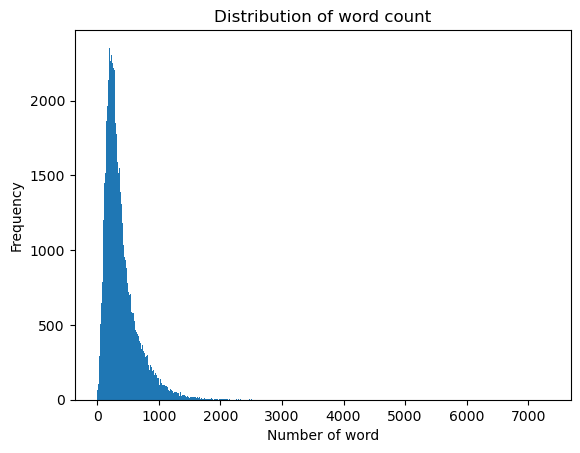

In [58]:
import matplotlib.pyplot as plt

plt.hist(jobs_df['word_count'], bins='auto')
plt.xlabel('Number of word')
plt.ylabel('Frequency')
plt.title('Distribution of word count')
plt.show()

## Handling long documents with chunking
There are many long postings. As the sentence transformer model we are using only takes in 256 word pieces at a time, we will chunk the text from each document based on paragraphs and word +punctuation length, to create chunks of paragraphs with less than 200 words/punctuations each. We will also include an overlap of about 30 words/punctuations to preserve context. 


In [59]:
def chunk_document_id(job_id, text, word_limit = 200, overlap = 30):
    """
    Splits a document into word-count limited chunks with overlap, 
    and returns a list of dictionaries including the original job_id.
    """
    
    # Split the document into paragraphs (on blank lines or single newlines)
    paragraphs = re.split(r'\n\s*\n', str(text).strip())
    paragraphs = [p.strip() for p in paragraphs if p.strip()] # Remove empty strings
    
    chunks = []
    current_chunk_words = []
    current_word_count = 0

    for paragraph in paragraphs:
        paragraph_words = paragraph.split()
        paragraph_word_len = len(paragraph_words)

        if paragraph_word_len > word_limit:

            # First, save any existing aggregate chunk (if not empty)
            if current_chunk_words:
                chunks.append({"job_id_chunk": job_id, "text_chunk": " ".join(current_chunk_words)})
                current_chunk_words = []
                current_word_count = 0
            
            # Split the long paragraph into overlapping sub-chunks
            start = 0
            while start < paragraph_word_len:
                end = min(start + word_limit, paragraph_word_len)
                sub_chunk_words = paragraph_words[start:end]
                chunks.append({"job_id_chunk": job_id, "text_chunk": " ".join(sub_chunk_words)})
                
                # Set the next start point, applying the overlap
                start = end - overlap
                
                # Handle the very last chunk so we don't start the next loop past the end
                if end == paragraph_word_len:
                    break
            
            continue

        if current_word_count + paragraph_word_len <= word_limit:
            # If the paragraph fits with the current aggregate chunk, add it
            current_chunk_words.extend(paragraph_words)
            current_word_count += paragraph_word_len
        
        else:
            # Save the current chunk
            if current_chunk_words:
                chunks.append({"job_id_chunk": job_id, "text_chunk": " ".join(current_chunk_words)})
                
            # Start a new chunk with the current paragraph
            current_chunk_words = paragraph_words
            current_word_count = paragraph_word_len
            
    # 3. Save the final aggregate chunk
    if current_chunk_words:
        chunks.append({"job_id_chunk": job_id, "text_chunk": " ".join(current_chunk_words)})
        
    return chunks

In [60]:
jobs_df['chunk_data'] = jobs_df.apply(lambda row: chunk_document_id(row['job_id'], row['norm_td']), axis=1)
df_final = jobs_df.explode('chunk_data', ignore_index=True)
df_final[['job_id_chunk', 'text_chunk']] = pd.json_normalize(df_final['chunk_data'])
df_final.drop('chunk_data', axis=1, inplace=True)
chunk_df=df_final[['job_id_chunk', 'text_chunk']]


In [61]:
# check chunks
duplicate_job_ids = chunk_df['job_id_chunk'].value_counts()
duplicate_job_ids = duplicate_job_ids[duplicate_job_ids > 1].index.tolist()
chunk_df[chunk_df['job_id_chunk'].isin(duplicate_job_ids)].head(5)

,job_id_chunk,text_chunk
0,74630583,"Procurement Executive ( Contract ) . Position Purpose Manage aspects of procurement including supplier management , contract management , and vendor performance tracking . Support the administration and management of procurement processes . This includes setting up , maintaining , and administering purchasing databases ; developing and issuing purchase orders ; maintain contract log and providing support to other departments within the organization who are involved in procurement . Key Duties / Responsibilities General Ensure the PO created following the bidding requirements OA updates from time to time - upon request from planning team / buyers Geographical coverage : Malaysia and Singapore operations Ensure all purchasing activities comply with Procurement Procedure and company internal policy Actively seek out opportunities for improvement , ways to do things better ; and lead implementation of actions defined Manage reports and reviews Manage reports and reviews weekly , monthly and quarterly accordingly Contract Log Update ; Ensure expiring / expired contracts are renewed on time ; Safekeeping of contracts softcopy Active and Inactive Vendor Code Cleansing on quarterly basis Supplier management : Define and implement strategy for supplier management to ensure reliability in consistently meeting requirements , quality control and product performance per contract"
1,74630583,"Code Cleansing on quarterly basis Supplier management : Define and implement strategy for supplier management to ensure reliability in consistently meeting requirements , quality control and product performance per contract , continuous improvement in cost , quality and service . Vendor Creation follows the policy and acknowledgment from respective buyers Documentation and Audit : Keep record of PAF , PAF approvals , Bidding documents , Contracts softcopies Work closely with Legal in contract storage and contract log Keep track on all report as evidence for audit . Requirements / Qualifications Education : Bachelor Degree preferably in procurement and / or supply chain related field . Professional knowledge of procurement practices , supply markets , terms , negotiation concepts and business laws . Experience : 1 - 2 years ’ experience relevant experience in FMCG / beverage manufacturing environment or any other related field with a strong procurement background in Malaysia . Language : Bahasa Melayu / English Work Location : Bandar Enstek ( Negeri Sembilan ) Employment : 12 months Contract With Regret , only shortlisted candidate will be notified ."
4,74657624,"Service Engineer . You are important for troubleshooting , installation , maintenance and service repair needs on designated equipment . You are important for conducting preventative maintenance service as per given schedule You are needed to keep up to date on administrative responsibilities such as maintaining customer service logs and internal service records in a timely manner . You are needed to participate in sales opportunities such as contract renewals and assist with promoting and implementing revenue programs . You are needed to include training of clinical staff for designated equipment . Candidate must possess at least Diploma / Advanced / Higher / Graduate Diploma , Bachelor ' s Degree / Post Graduate Diploma / Professional Degree in Engineering ( Bioengineering / Biomedical ) , Engineering ( Electrical / Electronic ) or equivalent . Required language ( s ) : English ( must be able to converse fluently ) and Bahasa Malaysia Must be willing to work in PUCHONG At least 2 Year ( s ) of working experience in the related field is required for this position . Required Skill ( s ) : Non invasive cardiology equipments , patient monitoring , fetal monitors , AED , , Defibrillators"
5,74657624,"the related field is required for this position . Required Skill ( s ) : Non invasive cardiology equipments , patient monitoring , fetal monitors , AED , , Defibri

In [63]:
#save chunk dictionary 
with open(os.path.join(output_directory,'chunk_df.pkl'), 'wb') as file:
    pickle.dump(chunk_df, file)

In [18]:
documents=chunk_df['text_chunk'].tolist()

# Import required packages
from sentence_transformers import SentenceTransformer
import chromadb

# Load model optimized for sentence/text embedding
model = SentenceTransformer('all-MiniLM-L6-v2')

c:\Users\erica\anaconda3\envs\TextAnalyticsProj\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
# # below is commented out to avoid long run time. uncomment out

# #embed documents
# doc_embeddings=model.encode(documents, show_progress_bar=True).tolist()

In [20]:
# create/load client and collection in vector database
client=chromadb.PersistentClient(path=os.path.join(output_directory, 'sbert_database'))
collection = client.get_or_create_collection(
    name='job_posting_chunks', 
    embedding_function=None,
    metadata={"hnsw:space":"cosine"} #ensure similarity metric is using cosine
 )


In [21]:
# # #commented out below code as doc_embeddings above is commented out

# metadata=chunk_df[['job_id_chunk']].to_dict('records')
# documents=chunk_df['text_chunk'].tolist()
# ids=chunk_df.index.tolist()
# ids=[str(x) for x in ids]

# # since there are 169036 documents from chunk_df, need to add in batches
# # max batch size for .add() is 5461
# total_size = len(chunk_df)
# MAX_BATCH_SIZE = 5461 

# # --- 1. Define the Chunking Function ---
# def chunk_data(data_list, chunk_size):
#     """Yield successive n-sized chunks from a list."""
#     for i in range(0, len(data_list), chunk_size):
#         yield data_list[i:i + chunk_size]

# # --- 2. Chunk All Parallel Lists ---
# # We use the zip function to create an iterator of chunks for all four lists
# # The number of chunks will be total_size / MAX_BATCH_SIZE (approx 31 chunks)
# batch_iterator = zip(
#     chunk_data(doc_embeddings, MAX_BATCH_SIZE),
#     chunk_data(documents, MAX_BATCH_SIZE),
#     chunk_data(metadata, MAX_BATCH_SIZE),
#     chunk_data(ids, MAX_BATCH_SIZE)
# )

# # --- 3. Iterate and Add to Collection ---
# batch_count = 0
# for embed_batch, doc_batch, metadata_batch, id_batch in batch_iterator:
#     batch_count += 1
#     print(f"Adding batch {batch_count} of size {len(embed_batch)}...")
    
#     # Add the current chunk to the ChromaDB collection
#     try:
#         collection.add(
#             embeddings=embed_batch,
#             documents=doc_batch,
#             metadatas=metadata_batch,
#             ids=id_batch
#         )
#         print(f"Batch {batch_count} added successfully.")
#     except Exception as e:
#         print(f"Error adding batch {batch_count}: {e}")

# print(f"\nCompleted adding {total_size} total documents in {batch_count} batches.")

# Build BERT + Cosine Similarity Doc Retrieval Pipeline

## Get inverted index

In [22]:
# Inverted index 
with open('output/inverted_index.pkl', 'rb') as file:
    postings = pickle.load(file)

#vocab
with open('output/vocab.pkl', 'rb') as file:
    vocab=pickle.load( file)

## Create Categorical Filters

In [23]:
# list all values in each of the categorical fields we are using for filter in Series format
state_arr = jobs_df["State"].astype(str).values
type_arr = jobs_df["type_clean"].values
merged_category_arr = jobs_df["merged_category"].astype(str).values

N = len(jobs_df) # Size of the corpus

In [24]:
# Assume data passed in already has validity checks on Front End
def facet_mask(state=None, job_type=None, merged_category=None):
    m = np.ones(N, dtype=bool) # Initialise an array m of all True first, assume no filters added
    if state is not None: # check if a filter was used by the user, if there is a value passed in      
        m &= (state_arr == str(state)) # check docs that fulfil the user's passed in value, reassign back to mask m
    if job_type is not None:
        if isinstance(job_type, list) and len(job_type) > 0: 
            # normalize case once
            sel = [s.lower() for s in job_type]
            m &= np.fromiter(
                (any((t.lower() in sel) for t in type_arr[i]) for i in range(N)),
                dtype=bool,
                count=N
            )
    if merged_category is not None:    
        m &= (merged_category_arr == str(merged_category))
    return m

## Query parsing

`expand_query()` -> used for query expansion to retrieve potentially relevant candidate documents </br>
`process_query()` -> used for retrieving word embeddings of query using BERT 

In [25]:
# import packages to re-use functions used in cleaning text for database
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.wsd import lesk

'''
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
'''

def normalize_text(text):
    text = re.sub(r'<.*?>', ' ', text)                     # remove HTML tags
    text = re.sub(r'\\n|\n', ' ', text)                    # remove newlines
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)            # keep letters & numbers only
    text = text.lower()                                    # lowercase
    text = re.sub(r'\s+', ' ', text).strip()               # normalize spaces
    return text

stop_words = set(stopwords.words("english"))
custom_stop = {"experience","responsibilities","requirements","requirement","knowledge",
    "skill","skills","advantage","preferred","strong","good","excellent",
    "degree","diploma","bachelor","graduate","title",
    "independent","self-motivated","hardworking",
    "deadline","pressure","benefits","apply","immediately", "writing","spoken","etc","others","job","work","company",
    "candidate","menu","new","plus","years","revenue","ensure", "provide", "including", "malaysia"}
stop_words |= custom_stop
stop_words |= set(stopwords.words("indonesian")) # unable to find malay stopword, hence using indonasian which is relatively close
lemmatizer = WordNetLemmatizer()

# get POS tagging
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return None
    


### Expand Query

In [26]:
def expand_query(text):
    sentences = sent_tokenize(text)
    words= []
    pos_tags=[]
    
    for sent in sentences:
        w = word_tokenize(sent)  
        words+=w
        tags=pos_tag(w) 
        pos_tags+=tags 
                        
    expanded_queries = []
    for word, pos in zip(words, pos_tags):
        pos = get_wordnet_pos(pos[1])
        synsets = wordnet.synsets(word, pos=pos)
        if synsets:
            correct_synset = lesk(words, word, pos=pos)
            if correct_synset:
                max_similarity = 0
                most_similar_synset = None
                for synset in synsets:
                    similarity = correct_synset.path_similarity(synset)
                    if similarity and similarity > max_similarity:
                        max_similarity = similarity
                        most_similar_synset = synset
                if most_similar_synset:
                    expanded_queries+=most_similar_synset.lemma_names()
            else:
                expanded_queries.append(word)
        else:
            expanded_queries.append(word)

    tokens=[]

    #include cleaning steps used to clean original database
    for word in expanded_queries: 
        w=normalize_text(word)
        if w.isalpha() and w not in stop_words:        
            lemma = lemmatizer.lemmatize(w)           
            tokens.append(lemma)

    return tokens

In [27]:
# text query expansion test
expand_query("operations analyst")

['process', 'operation', 'analyst', 'psychoanalyst']

### Filter for company name in query

In [28]:
# M'sian company names only allow letters, numbers, &, period, hyphen, ', ()
# But the useful ones are letters, numbers, & (convert to 'and')
def light_normalize(text):
    s = text.lower()
    s = re.sub(r"[^a-z0-9\s&]", " ", s) # Keep only useful characters
    s = s.replace("&", " and ") # replace & with and, similar treatment as company gazatteer
    s = re.sub(r"\s+", " ", s).strip() # collapse multiple white space if any
    return s

In [29]:
# Check for simple event template
event_pat = re.compile(r'\b(?:at|with|for|from)\s+([a-z0-9 ]{2,})$', re.I)

def event_pat_search(text):
    m = event_pat.search(text)
    return [m.group(1)] if m else []

In [30]:
jobs_df.columns

Index(['job_id', 'job_title', 'company', 'descriptions', 'State',
       'merged_category', 'category', 'subcategory', 'role_clean',
       'type_clean', 'salary', 'processed_title+desc', 'processed_text',
       'company_clean', 'title_desc', 'norm_td', 'word_count', 'chunk_data'],
      dtype='object')

In [31]:
# Define role stop words (this is different from the normal stop words. e.g. procurement executive apple, 
# we want 'procurement executive' to be cleaned off because these are words not used in company names)
# Cannot clean off location words as could be part of the company name (e.g. Royal Selangor Association), except "Malaysia"

# Create keyword processor using FlashText (which is a phrase matcher)
# Throw in all the role_clean values inside since it's very comprehensive, act as role_stopwords
from flashtext import KeywordProcessor

role_keyword_processor = KeywordProcessor(case_sensitive=False)
role_keyword_list = jobs_df['role_clean'].str.lower().str.strip().dropna().tolist()

for p in role_keyword_list:
    if p:  # avoid empty strings
        role_keyword_processor.add_keyword(p, " ") # FlashText to replace with empty space (empty string doesnt work) when these phrases found

In [32]:
from nltk.corpus import stopwords

# Still add some custom stop words which are one-word to prevent more unintended matches to company names
# Intended result: No company matches, become general search with no company name filter.
role_stopwords = {
    "intern", "internship", "role", "roles", "job", "jobs", "position", "positions", 
    "career", "careers", "vacancy", "vacancies", "lead", "senior", "junior",
    "remote", "hybrid", "office", "hiring", "malaysia", "analyst", "scientist", "executive",
    "manager", "engineer", "developer"
}

stop_words = set(stopwords.words("english"))
role_stopwords |= stop_words # Try to remove so it will cut down on the no. of N-grams formed

# N-gram sweep required for query cases with no prepositions, like "Apple jobs", "Shopee data scientist"
# Max use trigrams because majority of company names are 3 words
def ngram_sweep(text, n_max=3):
    cleaned_text = role_keyword_processor.replace_keywords(text)
    toks = [t for t in cleaned_text.split() if t not in role_stopwords]
    cands = set()
    for n in range(1, n_max+1): # extract unigram (0-1st pos), till trigram (0-4th pos). total 6 combis
        for i in range(len(toks) - n+1):
            cands.add(" ".join(toks[i:i+n]))
    return sorted(cands, key=lambda x: (-len(x.split()), -len(x))) # sort longer N-grams first

In [33]:
def extract_companies(text):
    s = light_normalize(text)
    cand_companies = list(set(event_pat_search(s) + ngram_sweep(s))) # Get all possible company names from the 2 methods
    return cand_companies

In [34]:
# Special helper function to fuzzy match candidate company names to the company gazatteer (companies)
def best_company(cand_companies, companies, cutoff=80):
    matches = [] # keep track of all successful fuzzy matches
    for cand in cand_companies: # feed all the possible candidates 
        if not cand:
            continue
        # cand=r'\b'+cand+r'\b'
        hits = process.extract( 
            cand,
            companies,
            scorer=fuzz.token_set_ratio
        )
        
        # keep only those >= cutoff
        for name, score, _ in hits:
            if score >= cutoff:
                # Append entire info (for troubleshooting code)
                # matches.append({
                #     "cand": cand,
                #     "matched_company": name,
                #     "score": float(score)
                # })

                matches.append(name)
            
    return matches # Note: may be empty list

### Get word embeddings for query

In [35]:
def normalize_text_bert(text):
    text = re.sub(r'<.*?>', ' ', text)                     # remove HTML tags
    text = re.sub(r'([^A-Za-z0-9\s])', r' \1 ', text)        # separate punctuation from words/numbers (e.g. executive/assistant -> executive / assistant)
    text = re.sub(r'[ \t]+', ' ', text)               # normalize horizontal spaces
    return text

def process_query(text, model=model):
    text = normalize_text_bert(text)
    query_embedding= model.encode(text)
    return query_embedding

In [36]:
process_query('janitor')

array([-6.19613007e-02,  8.36415887e-02,  2.15510931e-02,  4.47665602e-02,
       -6.33474020e-03, -5.48837148e-03,  4.72098142e-02, -2.56017670e-02,
       -3.60804051e-02,  5.98591939e-03, -2.43877135e-02, -4.97910008e-03,
       -9.28752869e-03,  3.56169343e-02, -4.05110642e-02, -2.30721254e-02,
       -8.88329092e-03,  4.50361334e-02, -4.69232872e-02, -2.44892798e-02,
       -7.01134130e-02,  4.65449831e-03,  2.46239733e-03, -3.73178571e-02,
        9.46255475e-02,  2.66209263e-02, -1.35905659e-02,  2.18985882e-02,
       -5.50264716e-02, -5.96786365e-02,  2.02623811e-02, -5.47712557e-02,
        3.30365188e-02, -6.37212023e-03, -1.69723469e-03,  4.67101038e-02,
        3.41392010e-02,  8.24043751e-02,  3.79610993e-02,  1.50522934e-02,
        1.44519480e-02, -8.79272819e-02,  5.91683462e-02, -6.44082278e-02,
        3.85886952e-02, -2.64658425e-02,  9.56408307e-03, -4.06113565e-02,
        3.15727815e-02, -2.89790742e-02, -1.28177851e-02, -3.97753455e-02,
        1.24090556e-02,  

## Build and get embeddings of candidate set

In [ ]:
def candidate_docs(query, state=None, job_type=None, merged_category=None):
    keywords = expand_query(query)
    cand_companies = extract_companies(query)

    # 1) Apply facet mask first to quickly reduce no. of documents to do keyword match on
    m = facet_mask(state=state, job_type=job_type, merged_category=merged_category)
    allowed_idx = np.flatnonzero(m) # returns indices where facet_mask is True
    allowed_set = set(allowed_idx) # Reduced candidate set for later

    # 2) Company filtering inside allowed_set. Strategy is to intersect allowed_set with company_set
    company_matches = best_company(cand_companies, companies, cutoff=80)
    if company_matches: # if there are results proceed to filter
        company_set = set(jobs_df.index[jobs_df['company_clean'].isin(company_matches)])
        allowed_set_intersect = allowed_set.intersection(company_set)
        # Only if there is intersection then we use the intersected set, else continue to use allowed_set
        if allowed_set_intersect:
            allowed_set = allowed_set_intersect  # use intersection

    # 3) Collect keyword candidates using inverted index, only keep docs in allowed_set
    cand = set()
    if keywords:
        for w in keywords:
            tid = vocab.get(w) # check if word in my vocab dictionary
            if tid is None: # Not found, ignore
                continue
            for d, _ in postings[tid]: # if found, get the document id
                if d in allowed_set:         # check if this doc id was in the reduced candidate set already
                    cand.add(d) # If it is, add to the set() called cand
    else:
        # No keywords: candidates are all postings based on categorical filters. 
        cand = set(allowed_idx)
        
    cand = np.array(sorted(cand), dtype=int)
    if len(cand) == 0:
        return None

    cand_ids=jobs_df.iloc[cand]['job_id'].tolist() # retrieve job ids of candidate documents
    cand_chunk_ids=chunk_df[chunk_df['job_id_chunk'].isin(cand_ids)].index.tolist()
    return cand_chunk_ids
    

In [45]:
chunk_df

,job_id_chunk,text_chunk
0,74630583,Procurement Executive ( Contract ) . Position ...
1,74630583,Code Cleansing on quarterly basis Supplier man...
2,74660602,Account Executive / Assistant . We are looking...
3,74655679,"Data Analyst - Asset Management , SPX Express ..."
4,74657624,Service Engineer . You are important for troub...
...,...,...
169031,83822822,"workshop events , as we prioritize work - life..."
169032,83822822,based on customer feedback Ensure adherence to...
169033,83822822,"Excel , PowerPoint ) Experience with virtual c..."
169034,83822822,Sdn Bhd is an equal opportunity employer . We ...


In [44]:
candidate_docs('retail store supervisor', state="Kuala Lumpur")

[135,
 136,
 244,
 245,
 286,
 287,
 288,
 352,
 353,
 377,
 378,
 419,
 420,
 421,
 422,
 510,
 511,
 647,
 648,
 649,
 650,
 651,
 652,
 653,
 665,
 666,
 667,
 668,
 669,
 670,
 808,
 809,
 848,
 849,
 919,
 920,
 939,
 1210,
 1211,
 1212,
 1213,
 1283,
 1284,
 1352,
 1416,
 1417,
 1447,
 1448,
 1449,
 1450,
 1451,
 1452,
 1453,
 1481,
 1482,
 1514,
 1515,
 1518,
 1519,
 1520,
 1540,
 1541,
 1542,
 1543,
 1592,
 1593,
 1594,
 1851,
 1852,
 1853,
 1880,
 1881,
 1882,
 1883,
 1884,
 1963,
 1964,
 1965,
 1996,
 1997,
 2031,
 2032,
 2033,
 2093,
 2094,
 2095,
 2096,
 2241,
 2242,
 2394,
 2395,
 2396,
 2406,
 2407,
 2408,
 2439,
 2440,
 2480,
 2481,
 2497,
 2498,
 2499,
 2500,
 2508,
 2509,
 2610,
 2611,
 2612,
 2613,
 3012,
 3013,
 3058,
 3059,
 3060,
 3061,
 3062,
 3083,
 3084,
 3143,
 3144,
 3261,
 3467,
 3468,
 3476,
 3477,
 3478,
 3479,
 3480,
 3527,
 3528,
 3543,
 3544,
 3545,
 3546,
 3574,
 3575,
 3576,
 3701,
 3702,
 3703,
 3759,
 3760,
 3761,
 3762,
 3866,
 3867,
 3868,
 3917,
 

## Score candidates with BERT 

In [38]:
def rank_BERT_cosine(query, k=10, state=None, job_type=None, merged_category=None, model=model):
    # Fetch the ids of candidate documents
    c_ids = candidate_docs(query, state=state, job_type=job_type, merged_category=merged_category)
    c_ids=[str(x) for x in c_ids]

    # Fetch the query embeddings
    q_bert = process_query(query)

    # perform cosine similarity calculation between query and chunks
    results = collection.query(
        query_embeddings=q_bert,
        ids=c_ids,
        n_results=50 #50 chunks should be sufficient to get results of at least 10 different job postings 
    )        

    job_ids=results['metadatas'][0]
    job_ids=[x['job_id_chunk'] for x in job_ids]
    c_df=pd.DataFrame({
        'job_id_chunk': job_ids,
        'score': results['distances'][0] #chromadb returns a distance score, where lower values close to 0 are better
    })

    # Perform aggregation to score each job posting by its minimum cosine distance with the query
    document_scores = c_df.groupby('job_id_chunk')['score'].min().reset_index()

    # Get top 10
    ranked_documents = document_scores.sort_values(by='score', ascending=True).head(10)

    # fetch original doc from jobs_df
    out = pd.merge(ranked_documents, jobs_df, left_on='job_id_chunk', right_on='job_id')
    out = out.sort_values(by='score', ascending=True)
    return out

## Example usage

In [39]:
pd.reset_option('all')

C:\Users\erica\AppData\Local\Temp\ipykernel_29416\2786130087.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\erica\AppData\Local\Temp\ipykernel_29416\2786130087.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


In [40]:
result = rank_BERT_cosine(
    "procurement executive",
    k=10,
    state="Selangor",
    job_type=['Full time'],
    merged_category="Accounting & Finance"
)

result[['job_id', 'job_title', 'descriptions', 'score']]

,job_id,job_title,descriptions,score
0,74257732,Purchasing Executive,Sri KDU International School Subang Jaya\nis l...,0.416723
1,74045512,Accounts Cum Procurement Executive,Account Role:\nOrganize the bookkeeping proces...,0.430616
2,74597853,PTP Account Executive,A PTP (Procure-to-Pay) Account Executive is a ...,0.490498
3,75582988,PTP Account Executive,A PTP (Procure-to-Pay) Account Executive typic...,0.502724
4,73976758,Finance Controlling Executive (Product Supply),Position Summary\nThe\nFinance Controlling Exe...,0.514921
5,83379490,Senior Accounts Executive,Job Description\nWe are seeking a meticulous a...,0.515714
6,74088635,Accounts Executive,"Process all invoices, credit notes, debit note...",0.525427
7,72977149,Finance Executive,We are looking for a Mid/ Senior Finance Execu...,0.525942
8,75086651,ACCOUNT EXECUTIVE,About us\nEstablish company for 10 years in tr...,0.529515
9,74227117,Account Executive,Job Responsibilities:\nResponsible for process...,0.531892


In [41]:
result = rank_BERT_cosine("Retail store supervisor", 
                  state="Kuala Lumpur")
result

,job_id_chunk,score,job_id,job_title,company,descriptions,State,merged_category,category,subcategory,role_clean,type_clean,salary,processed_title+desc,processed_text,company_clean,title_desc,norm_td,word_count,chunk_data
0,74946628,0.260664,74946628,RETAIL STORE SUPERVISOR (PAVILION KUALA LUMPUR),Wicked Wave Sdn Bhd,RETAIL STORE SUPERVISOR:\nJob Responsibilities...,Kuala Lumpur,Hospitality & Services,Retail & Consumer Products,Management - Store,Retail Store Supervisor,[full time],NaN,retail store supervisor pavilion kuala lumpur ...,retail store supervisor pavilion kuala lumpur ...,wicked wave,RETAIL STORE SUPERVISOR (PAVILION KUALA LUMPUR...,RETAIL STORE SUPERVISOR ( PAVILION KUALA LUMPU...,299,"[{'job_id_chunk': 74946628, 'text_chunk': 'RET..."
1,74799697,0.289371,74799697,"Retail Supervisor (Fashion, Menswear)",AGENSI PEKERJAAN JS STAFFING SERVICES SDN BHD,Key Duties\nMotivate sales staff to ensure the...,Kuala Lumpur,Hospitality & Services,Retail & Consumer Products,Management - Store,Store Supervisor,[full time],"RM 3,500 – RM 5,000 per month",retail supervisor fashion menswear key duty mo...,retail supervisor fashion menswear agensi peke...,agensi pekerjaan js staffing services,"Retail Supervisor (Fashion, Menswear). Key Dut...","Retail Supervisor ( Fashion , Menswear ) . Key...",183,"[{'job_id_chunk': 74799697, 'text_chunk': 'Ret..."
2,74733231,0.316558,74733231,Assistant Operations Manager,SK Jewellery Sdn Bhd,RESPONSIBILITIES:\nResponsible for supervising...,Kuala Lumpur,Hospitality & Services,Retail & Consumer Products,Management - Area/Multi-site,Assistant Operations Manager,[full time],"RM 5,000 – RM 7,000 per month",assistant operation manager responsible superv...,assistant operation manager sk jewellery sdn b...,sk jewellery,Assistant Operations Manager. RESPONSIBILITIES...,Assistant Operations Manager . RESPONSIBILITIE...,242,"[{'job_id_chunk': 74733231, 'text_chunk': 'Ass..."
3,74911355,0.341506,74911355,Assistant Area Manager,NEW BALANCE ATHLETIC SHOES SDN.BHD.,We are looking for a talented candidate to und...,Kuala Lumpur,Social & Community / Other,Community Services & Development,"Child Welfare, Youth & Family Services",Area Manager,[full time],NaN,assistant area manager looking talented undert...,assistant area manager balance athletic shoe s...,new balance athletic shoes,Assistant Area Manager. We are looking for a t...,Assistant Area Manager . We are looking for a ...,662,"[{'job_id_chunk': 74911355, 'text_chunk': 'Ass..."
4,74936916,0.346174,74936916,Full Time - Retail Sales Advisor (Klang Valley),Machines Sdn Bhd,Jobs Responsibilities:\nLiaising with customer...,Kuala Lumpur,Hospitality & Services,Retail & Consumer Products,Retail Assistants,Retail Sales Advisor,[full time],NaN,full time retail sale advisor klang valley job...,full time retail sale advisor klang valley mac...,machines,Full Time - Retail Sales Advisor (Klang Valley...,Full Time - Retail Sales Advisor ( Klang Valle...,118,"[{'job_id_chunk': 74936916, 'text_chunk': 'Ful..."
5,75409862,0.347568,75409862,Assistant Retail & Operation Manager,CXT GROUP SDN. BHD.,Job Descriptions:\nOversee and maintain effici...,Kuala Lumpur,Hospitality & Services,Retail & Consumer Products,Management - Store,Retail Operations Manager,[full time],"MYR 3,500 - 4,800",assistant retail operation manager description...,assistant retail operation manager cxt group s...,cxt,Assistant Retail & Operation Manager. Job Desc...,Assistant Retail & Operation Manager . Job Des...,233,"[{'job_id_chunk': 75409862, 'text_chunk': 'Ass..."
6,74683198,0.347758,74683198,Jewelry Sales Supervisor (English & Mandarin),Yukimoto Gemstone Sdn Bhd,About Us:\nYukimoto is a premier boutique cele...,Kuala Lumpur,Hospitality & Services,Retail & Consumer Products,Management - Department/Assistant,Sales Supervisor,[full time],"RM 4,500 – RM 6,000 per month",jewelry sale supervisor english mandarin u yuk...,jewelry sale supervisor english mandarin yukim...,yukimoto gemstone,Jewelry Sales Super